In [ ]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2023-11-05 20:37:55--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.205.157, 52.216.62.80, 52.217.202.72, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.205.157|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  48.6MB/s    in 0.3s    

2023-11-05 20:37:56 (48.6 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [ ]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

In [ ]:
with open(fname) as f:
    data = f.read()

In [ ]:
lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))
import os
fname = os.path.join("jena_climate_2009_2016.csv")

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [ ]:
with open(fname) as f:
    data = f.read()

In [ ]:
lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))
#Parsing the data


['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [ ]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]
#Plotting the temperature timeseries

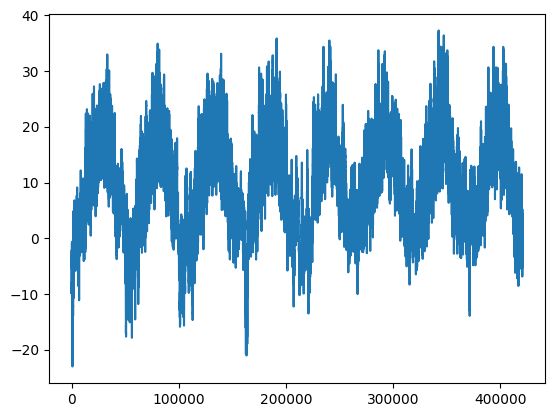

In [ ]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)
#Plotting the first 10 days of the temperature timeseries

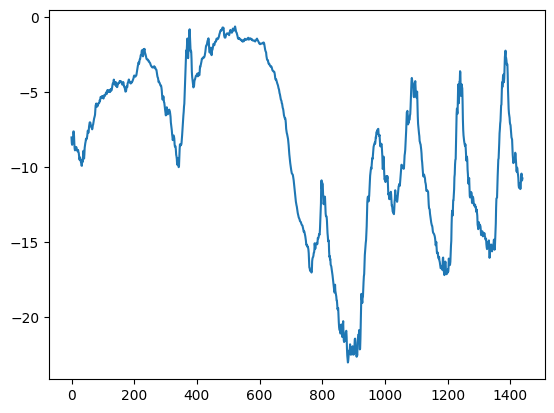

In [ ]:
plt.plot(range(1440), temperature[:1440])
#Computing the number of samples we'll use for each data split

In [ ]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)
#Preparing the data
#Normalizing the data

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


In [ ]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

In [ ]:
for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))
#Instantiating datasets for training, validation, and testing

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


In [ ]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

In [ ]:
train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

In [ ]:
val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

In [ ]:
test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)
#Inspecting the output of one of our datasets

In [ ]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break
#A common-sense, non-machine-learning baseline
#Computing the common-sense baseline MAE

samples shape: (256, 120, 14)
targets shape: (256,)


In [ ]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

In [ ]:
print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")
#Let's try a basic machine-learning model
#Training and evaluating a densely connected model

Validation MAE: 2.44
Test MAE: 2.62


In [ ]:
!pip install tensorflow==2.12

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")
#Plotting results

Epoch 1/10
819/819 [==============================] - 54s 60ms/step - loss: 12.6981 - mae: 2.7581 - val_loss: 9.8316 - val_mae: 2.4623
Epoch 2/10
819/819 [==============================] - 48s 58ms/step - loss: 8.5040 - mae: 2.2909 - val_loss: 10.2947 - val_mae: 2.5270
Epoch 3/10
819/819 [==============================] - 50s 61ms/step - loss: 7.3931 - mae: 2.1397 - val_loss: 11.2907 - val_mae: 2.6625
Epoch 4/10
819/819 [==============================] - 53s 64ms/step - loss: 6.6951 - mae: 2.0377 - val_loss: 10.2933 - val_mae: 2.5226
Epoch 5/10
819/819 [==============================] - 50s 61ms/step - loss: 6.1318 - mae: 1.9499 - val_loss: 12.0026 - val_mae: 2.7593
Epoch 6/10
819/819 [==============================] - 54s 65ms/step - loss: 5.7323 - mae: 1.8869 - val_loss: 11.1851 - val_mae: 2.6562
Epoch 7/10
819/819 [==============================] - 48s 59ms/step - loss: 5.3637 - mae: 1.8279 - val_loss: 12.1303 - val_mae: 2.7434
Epoch 8/10
819/819 [==============================] - 5

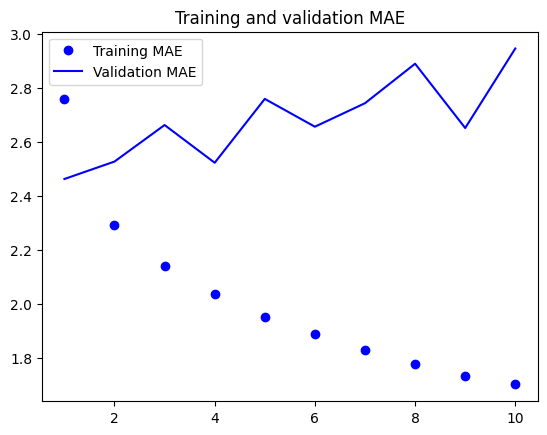

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()
#Let's try a 1D convolutional model
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)


Epoch 1/10
819/819 [==============================] - 67s 70ms/step - loss: 21.7993 - mae: 3.6800 - val_loss: 14.7487 - val_mae: 3.0473
Epoch 2/10
819/819 [==============================] - 52s 63ms/step - loss: 15.3717 - mae: 3.1155 - val_loss: 18.1223 - val_mae: 3.3196
Epoch 3/10
819/819 [==============================] - 55s 67ms/step - loss: 13.7420 - mae: 2.9362 - val_loss: 15.3407 - val_mae: 3.0925
Epoch 4/10
819/819 [==============================] - 55s 67ms/step - loss: 12.7929 - mae: 2.8287 - val_loss: 14.8984 - val_mae: 3.0420
Epoch 5/10
819/819 [==============================] - 55s 67ms/step - loss: 12.1025 - mae: 2.7486 - val_loss: 17.8988 - val_mae: 3.3586
Epoch 6/10
819/819 [==============================] - 50s 60ms/step - loss: 11.5951 - mae: 2.6888 - val_loss: 16.1141 - val_mae: 3.1668
Epoch 7/10
819/819 [==============================] - 51s 62ms/step - loss: 11.1536 - mae: 2.6365 - val_loss: 14.8419 - val_mae: 3.0521
Epoch 8/10
819/819 [============================

In [ ]:
model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")
#A first recurrent baseline
#A simple LSTM-based model

405/405 [==============================] - 17s 41ms/step - loss: 16.0490 - mae: 3.1699
Test MAE: 3.17


In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 61s 69ms/step - loss: 37.5473 - mae: 4.4655 - val_loss: 12.3679 - val_mae: 2.6798
Epoch 2/10
819/819 [==============================] - 54s 66ms/step - loss: 10.9567 - mae: 2.5710 - val_loss: 9.4764 - val_mae: 2.3960
Epoch 3/10
819/819 [==============================] - 52s 63ms/step - loss: 9.8341 - mae: 2.4436 - val_loss: 9.5945 - val_mae: 2.4118
Epoch 4/10
819/819 [==============================] - 62s 75ms/step - loss: 9.4139 - mae: 2.3905 - val_loss: 9.5638 - val_mae: 2.4091
Epoch 5/10
819/819 [==============================] - 52s 63ms/step - loss: 9.0549 - mae: 2.3434 - val_loss: 9.8328 - val_mae: 2.4351
Epoch 6/10
819/819 [==============================] - 55s 67ms/step - loss: 8.7937 - mae: 2.3124 - val_loss: 9.8392 - val_mae: 2.4332
Epoch 7/10
819/819 [==============================] - 57s 69ms/step - loss: 8.5957 - mae: 2.2837 - val_loss: 9.6473 - val_mae: 2.4140
Epoch 8/10
819/819 [==============================] - 58s 7

In [ ]:
model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")
#Understanding recurrent neural networks
#NumPy implementation of a simple RNN

405/405 [==============================] - 18s 42ms/step - loss: 10.4173 - mae: 2.5447
Test MAE: 2.54


In [ ]:
import numpy as np
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)
#A recurrent layer in Keras
#An RNN layer that can process sequences of any length

In [ ]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)
#An RNN layer that returns only its last output step

In [ ]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)
#An RNN layer that returns its full output sequence

(None, 16)


In [ ]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)
#Stacking RNN layers

(None, 120, 16)


In [ ]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)
#Advanced use of recurrent neural networks
#Using recurrent dropout to fight overfitting
#Training and evaluating a dropout-regularized LSTM

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)
#Stacking recurrent layers
#Training and evaluating a dropout-regularized, stacked GRU model

Epoch 1/10
819/819 [==============================] - 492s 597ms/step - loss: 29.2244 - mae: 3.9814 - val_loss: 9.5602 - val_mae: 2.4059
Epoch 2/10
819/819 [==============================] - 487s 594ms/step - loss: 14.9390 - mae: 2.9999 - val_loss: 9.4203 - val_mae: 2.3907
Epoch 3/10
819/819 [==============================] - 485s 592ms/step - loss: 13.9916 - mae: 2.9057 - val_loss: 9.0836 - val_mae: 2.3536
Epoch 4/10
819/819 [==============================] - 480s 586ms/step - loss: 13.3168 - mae: 2.8336 - val_loss: 9.4244 - val_mae: 2.3820
Epoch 5/10
819/819 [==============================] - 475s 580ms/step - loss: 12.8003 - mae: 2.7767 - val_loss: 9.0555 - val_mae: 2.3398
Epoch 6/10
819/819 [==============================] - 472s 575ms/step - loss: 12.3275 - mae: 2.7259 - val_loss: 9.2560 - val_mae: 2.3683
Epoch 7/10
819/819 [==============================] - 467s 570ms/step - loss: 12.0636 - mae: 2.6925 - val_loss: 8.9240 - val_mae: 2.3254
Epoch 8/10
819/819 [=====================

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)